<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/TrainingDataForDemosaicking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Data for Demosaicking
#### Qian, Mar 16



Idea: start with demosaicking to test synthetic images. Can start with single frame demosaicking and proceed to multiframe demosaicking.

Goal: 
* model trained on the synthetic data is able to extend to real data
* model trained on local patches works on whole frames

Reference: [Deep Joint Demosaicking and Denoising](https://groups.csail.mit.edu/graphics/demosaicnet/data/demosaic.pdf)

Notation: 
* J: ground truth full RGB frame
* I: color-coded frame

single-frame pipeline: *J* -> mosaic model -> *I* -> network -> *J_est* <---> *J*

multiframe general pipeline: 
$$J_t \rightarrow \text{mosaic model} \rightarrow  I_t$$ 
$$ \{I_t, I^{w*}_{t-1}, \dots, I^{w*}_{t-T}\}\rightarrow \text{network} \rightarrow J_t^{est} \cdots J_t$$

multiframe recurrent pipeline: 
$$J_t \rightarrow \text{mosaic model} \rightarrow  I_t$$ 
$$ \{I_t, J^{w*}_{t-1}\}\rightarrow \text{network} \rightarrow J_t^{est} \cdots J_t$$

\* In order to achieve the 2nd goal, reference frames in the multiframe pipeline are pre-warpped.

## Training Data in Blender 

In [1]:
! unzip -q drive/MyDrive/blender_frames_noisefree.zip

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
os.chdir("Image/")

In [3]:
def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

In [4]:
def load_exr(path):
    img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

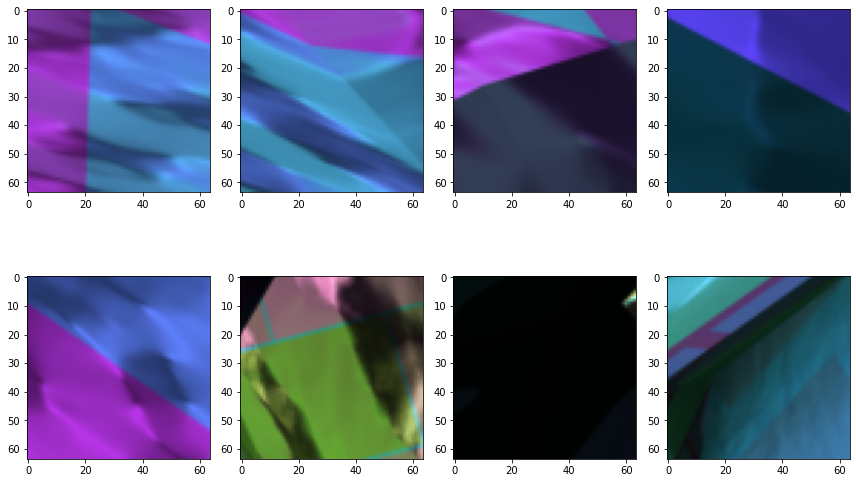

In [5]:
m, n = 2, 4
fig, ax = plt.subplots(m, n, figsize = (12, 8))
for i in range(m):
    for j in range(n):
        img = load_exr("Image{:04d}.exr".format(i * n + j + 1))
        ax[i][j].imshow(img/img.max())
plt.tight_layout()
plt.show()

### ~~problem: not noise free in low light region~~

currently the number of samples should be quite high (81920) to approxiate noise-free frames. Each frame under this setting takes ~3 mins to render on my PC.

## Mosaic Model

a simple pipeline to develop a mosaicked image from the field is: 

*field* -> noise model -> color filter array (CFA) -> *mosaicked image*

as described in Brook's [paper](https://arxiv.org/pdf/1811.11127.pdf). [Sumner](https://www.cnba.it/contenuti/uploads/2016/03/Processing-RAW-Images-in-MATLAB-Sumner.pdf) includes "linearization" and "white balance" blocks before CFA, which can be either unnecessary for Blender outputs (as sensor response are already linearized) or can be interchangeably moved after CFA.

Some parameters and configurations are adapted from Evetar lens( 25mm, F/2.4) and CMOS image sensor (Sony IMX274 4K). But some (like the amplitude factor between the light intensity and the pixel response is intractable) are set without the reference of the camera but considered along with the synthetic data properties.

---
reference: [link](https://photo.stackexchange.com/questions/72505/what-does-linearization-mean-in-raw-processing/92367), [link](https://www.rcsumner.net/raw_guide/)

### Noise Model

signal-dependent noise model, i.e., 
$y = \mathcal{N}(x, \sigma^2 = \sigma_r^2 + \sigma_s x)$, where  
- $y$: measurement
- $x$: groundtruth
- $\sigma_r$: read noise coefficient
- $\sigma_s$: shot noise coefficient


### CFA
apply Bayer filter and follow RGGB pattern.

In [22]:
class camMosaicModel:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 1000

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img
    
    def develop(self, img_gt, is_clean = False):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        if is_clean:
            img_noisy = img 
        else:
            img_noisy = self.noise_model(img_gt)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

## Generate Training pairs via Mosaic Model



### ground truth frame $J$

Array shape:  (64, 64, 3) dtype: float32
Array stat: max: 0.2783203125, min: 0.00836944580078125, mean: 0.07761788368225098, std: 0.04950729385018349
Dynamic range is 5.1 bits


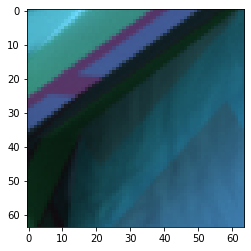

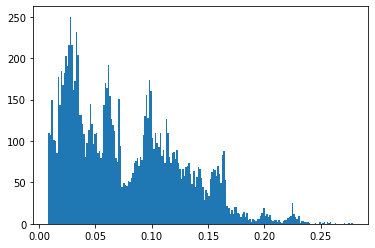

In [23]:
img = load_exr("Image0008.exr")
print_stat(img)
print("Dynamic range is {:.1f} bits".format(np.log2(img.max()/img.min())))
plt.imshow(img/img.max())
plt.show()
plt.hist(img.flatten(), bins=200)
plt.show()

display bright area and dark area

Array shape:  (16, 16, 3) dtype: float32
Array stat: max: 0.2783203125, min: 0.0599365234375, mean: 0.1497262716293335, std: 0.05826051905751228
Array shape:  (16, 16, 3) dtype: float32
Array stat: max: 0.0771484375, min: 0.00926971435546875, mean: 0.02725558541715145, std: 0.015368307940661907


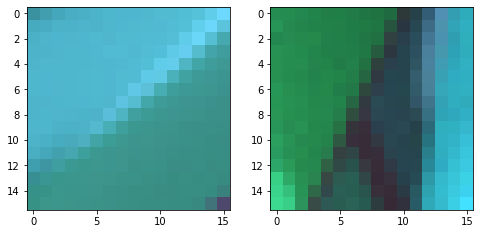

In [24]:
print_stat(img[:16,:16])
print_stat(img[-16:, :16])
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(img[:16,:16]/img[:16,:16].max())
ax[1].imshow(img[-16:, :16]/img[-16:, :16].max())
plt.show()

### raw measurement $I$

In [25]:
cam = camMosaicModel()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(img)

camera measurement raw and distribution

Array shape:  (64, 64, 3) dtype: uint16
Array stat: max: 329, min: 57, mean: 127.59757486979167, std: 49.57173441430814


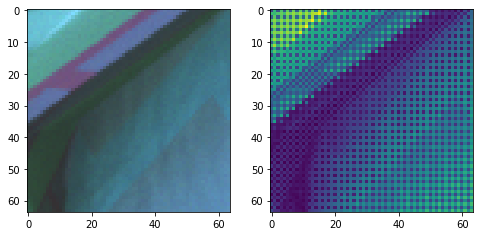

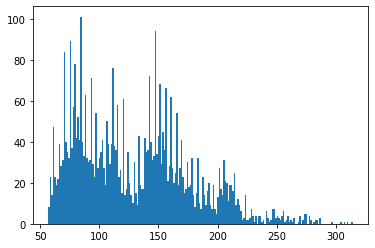

In [30]:
print_stat(sensor_noisy)
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy/sensor_noisy.max())
ax[1].imshow(bayer_noisy/bayer_noisy.max())
plt.show()
plt.hist(bayer_noisy.flatten(), bins=200)
plt.show()

same areas after applying camera model

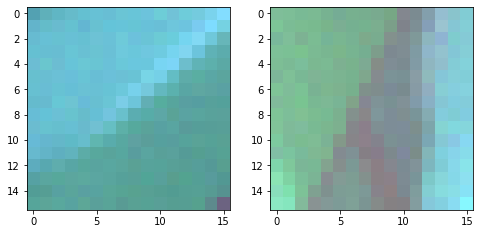

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy[:16,:16]/sensor_noisy[:16,:16].max())
ax[1].imshow(sensor_noisy[-16:, :16]/sensor_noisy[-16:, :16].max())
plt.show()